## Compare on Hard Examples

We've built up some intuition about each detection algorithm based on how it performed on two easy videos. To get a better sense of how each algorithm compares, let's take a look at how they perform on a few challenging videos.

We would like some of the following:
 - Side profile
 - Two people
 - Very Dark
 - Face heavily obscured by deep fake

In [1]:
import cv2
import torch
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pathlib import Path
from tqdm.notebook import tqdm
from utils import read_frame, plot_detections, read_all_frames

In [2]:
data = Path("../data")

side_profile_fake = data/'dfdc_train_part_0/bqamrsyvnf.mp4'
side_profile_real = data/'dfdc_train_part_11/lqyckwtvnl.mp4'

two_people_fake = data/'dfdc_train_part_13/aanzliuzft.mp4'
two_people_real = data/'dfdc_train_part_4/bgpoldvzrh.mp4'

dark_scene_fake = data/'dfdc_train_part_14/bddpvihkew.mp4'
dark_scene_real = data/'dfdc_train_part_5/xyklkuuumr.mp4'

moving_fake = data/'dfdc_train_part_7/aqgbewikxk.mp4'
moving_real = data/'dfdc_train_part_8/nwzrdkxhql.mp4'

obscured_face_fake1 = data/'dfdc_train_part_11/czmmoyfilz.mp4'
obscured_face_fake2 = data/'dfdc_train_part_18/asifdtncje.mp4'
obscured_face_fake3 = data/'dfdc_train_part_12/asjzklsxgb.mp4'
obscured_face_fake4 = data/'dfdc_train_part_13/aisumjkudv.mp4'
obscured_face_fake5 = data/'dfdc_train_part_7/copybkdfji.mp4'

In [3]:
# Read first frame from each video
side_profile_fake_frame = read_frame(side_profile_fake)
side_profile_real_frame = read_frame(side_profile_real)

two_people_fake_frame = read_frame(two_people_fake)
two_people_real_frame = read_frame(two_people_real)

dark_scene_fake_frame = read_frame(dark_scene_fake)
dark_scene_real_frame = read_frame(dark_scene_real)

moving_fake_frame = read_frame(moving_fake)
moving_real_frame = read_frame(moving_real)

obscured_face_fake1_frame = read_frame(obscured_face_fake1)
obscured_face_fake2_frame = read_frame(obscured_face_fake2)
obscured_face_fake3_frame = read_frame(obscured_face_fake3)
obscured_face_fake4_frame = read_frame(obscured_face_fake4)
obscured_face_fake5_frame = read_frame(obscured_face_fake5)

## Face Detection Algorithms

Each face detection algorithm has a `.detect()` method that accepts a frame and returns a numpy array containing one or more detection. Each detecion is formatted as:

`x_min, y_min, x_max, y_max, probability`

This was the most common format so we've changed a few implementations to mimic it.

In [4]:
from EasyMTCNN import EasyMTCNN
from EasyBlazeFace import EasyBlazeFace
from EasyDSFD import EasyDSFD
from EasyLightDSFD import EasyLightDSFD
from EasyRetinaFace import EasyRetinaFace

In [5]:
easyMTCNN = EasyMTCNN()
detections = easyMTCNN.detect(obscured_face_fake1_frame)
detections

array([[8.8257336e+02, 2.0984476e+02, 1.0551838e+03, 4.7453741e+02,
        9.9999487e-01]], dtype=float32)

In [9]:
easyBlazeFace = EasyBlazeFace()
detections = easyBlazeFace.detect(obscured_face_fake1_frame)
detections

array([[[tensor(872.1163, device='cuda:0'),
         tensor(228.0597, device='cuda:0'),
         tensor(1125.5496, device='cuda:0'),
         tensor(481.4937, device='cuda:0'),
         tensor(0.9096, device='cuda:0')]]], dtype=object)

In [11]:
frame_detections = easyBlazeFace.get_detections_with_multiple_crops(obscured_face_fake1_frame)
frame_detections

[array([[8.63283081e+02, 2.38937256e+02, 1.11099414e+03, 4.86648987e+02,
         9.55573440e-01]])]

In [12]:
easyDSFD = EasyDSFD()
detections = easyDSFD.detect(obscured_face_fake1_frame)
detections

Finished loading model!


array([[8.9168127e+02, 2.0732820e+02, 1.0640057e+03, 4.7543619e+02,
        9.9998236e-01]], dtype=float32)

In [13]:
easyLightDSFD = EasyLightDSFD()
detections = easyLightDSFD.detect(obscured_face_fake1_frame)
detections

/home/josh/anaconda3/envs/dl/lib/python3.7/site-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/josh/anaconda3/envs/dl/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)

array([[8.7907959e+02, 2.0134608e+02, 1.0525828e+03, 4.7585651e+02,
        9.9953139e-01]], dtype=float32)

In [14]:
easyRetinaFace = EasyRetinaFace()
detections = easyRetinaFace.detect(obscured_face_fake1_frame)
detections

Loading pretrained model from Pytorch_Retinaface/weights/Resnet50_Final.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:456


array([[8.8448267e+02, 1.9963495e+02, 1.0465510e+03, 4.7870819e+02,
        9.9886441e-01]], dtype=float32)

## Side Profile

Some algorithms seemed to have trouble with side profiles where the person's face partially hidden. Let's see how each algorithm performs here.

In [15]:
def test_detections_on_frame(frame):
    print("MTCNN")
    detections = easyMTCNN.detect(frame)
    plot_detections(frame, detections, figsize=(5,5))
    plt.show()
    
    print("BlazeFace")
    detections = easyBlazeFace.detect(frame)
    plot_detections(frame, detections[0], figsize=(5,5))
    plt.show()
    
    print("BlazeFace with multiple crops")
    detections = easyBlazeFace.get_detections_with_multiple_crops(frame)
    plot_detections(frame, detections[0], figsize=(5,5))
    plt.show()
    
    print("Dual Shot Face Detection")
    detections = easyDSFD.detect(frame)
    plot_detections(frame, detections, figsize=(5,5))
    plt.show()
    
    print("Light DSFD")
    detections = easyLightDSFD.detect(frame)
    plot_detections(frame, detections, figsize=(5,5))
    plt.show()
    
    print("RetinaFace")
    detections = easyRetinaFace.detect(frame)
    plot_detections(frame, detections, figsize=(5,5))
    plt.show()

MTCNN
Found 2 faces


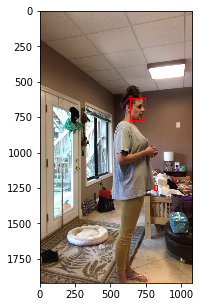

BlazeFace
Found 0 faces


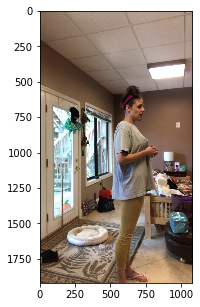

BlazeFace with multiple crops
Found 1 faces


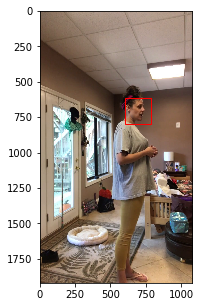

Dual Shot Face Detection
Found 1 faces


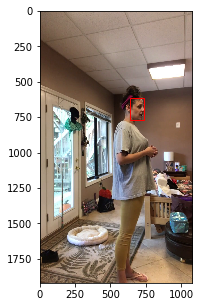

Light DSFD
Found 1 faces


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


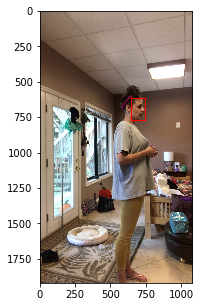

RetinaFace
Found 1 faces


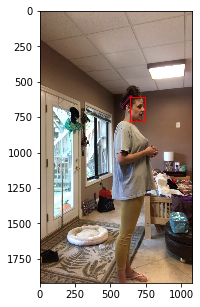

In [16]:
test_detections_on_frame(side_profile_fake_frame)

MTCNN
Found 1 faces


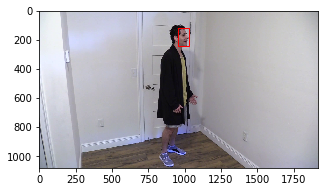

BlazeFace
Found 0 faces


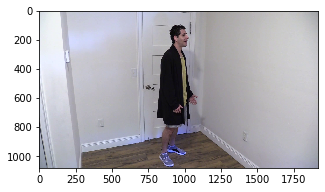

BlazeFace with multiple crops
Found 1 faces


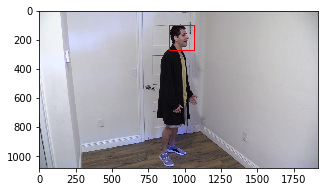

Dual Shot Face Detection
Found 1 faces


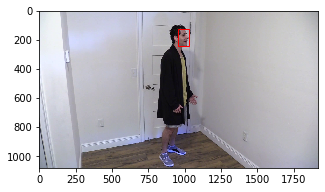

Light DSFD
Found 1 faces


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


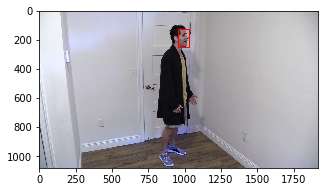

RetinaFace
Found 1 faces


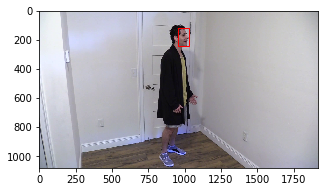

In [17]:
test_detections_on_frame(side_profile_real_frame)

For both images, all detectors worked except for BlazeFace.

It's possible that squishing the video to `128x128` is causing some problems.

It's also possible that BlazeFace isn't that great. 

## Two People

Some videos contain two people, can our detectors correctly find both people?

MTCNN
Found 2 faces


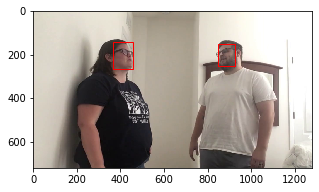

BlazeFace
Found 2 faces


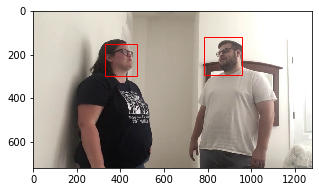

BlazeFace with multiple crops
Found 2 faces


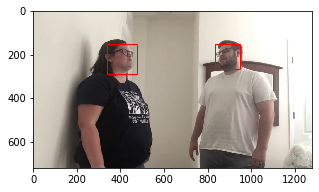

Dual Shot Face Detection
Found 2 faces


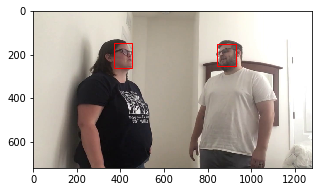

Light DSFD
Found 2 faces


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


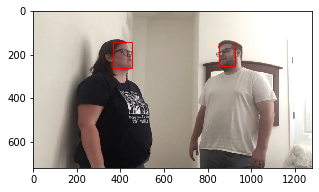

RetinaFace
Found 2 faces


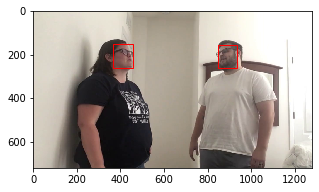

In [18]:
test_detections_on_frame(two_people_fake_frame)

MTCNN
Found 2 faces


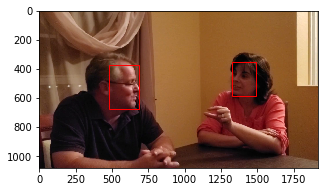

BlazeFace
Found 2 faces


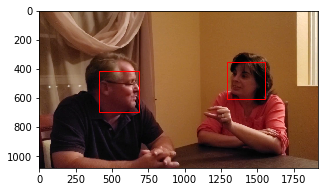

BlazeFace with multiple crops
Found 2 faces


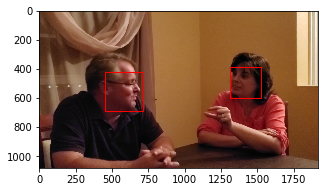

Dual Shot Face Detection
Found 2 faces


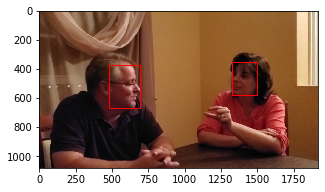

Light DSFD
Found 2 faces


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


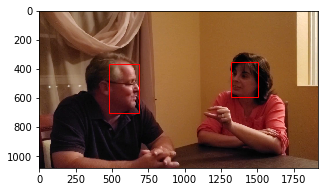

RetinaFace
Found 2 faces


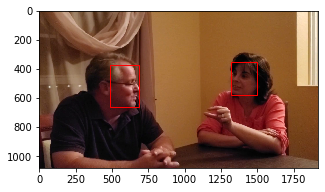

In [19]:
test_detections_on_frame(two_people_real_frame)

All detectors seemed to find both people.

## Very Dark Scenes

Some videos contain very dark scenes. Can we find the people in these scenes?

MTCNN
Found 1 faces


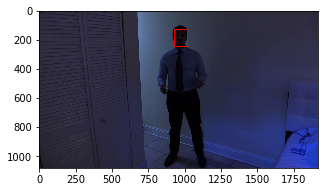

BlazeFace
Found 0 faces


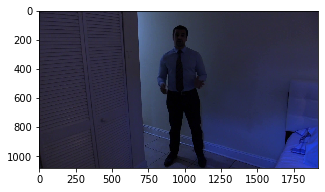

BlazeFace with multiple crops
Found 0 faces


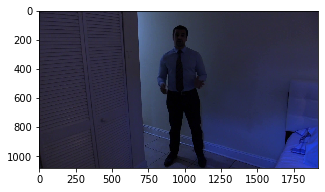

Dual Shot Face Detection
Found 1 faces


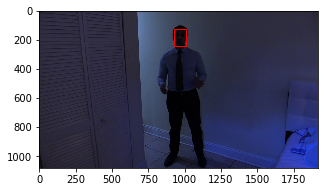

Light DSFD
Found 2 faces


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


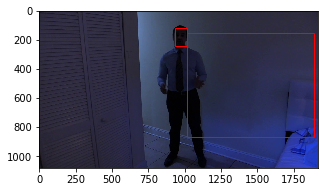

RetinaFace
Found 1 faces


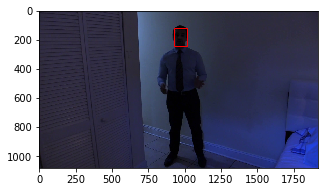

In [20]:
test_detections_on_frame(dark_scene_fake_frame)

MTCNN
Found 1 faces


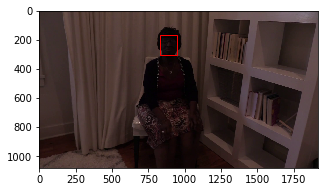

BlazeFace
Found 0 faces


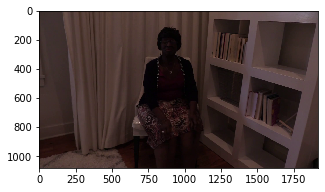

BlazeFace with multiple crops
Found 1 faces


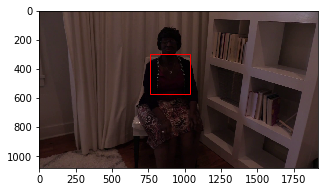

Dual Shot Face Detection
Found 1 faces


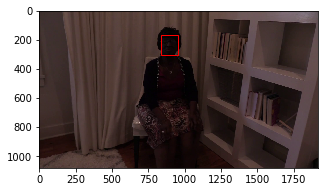

Light DSFD
Found 1 faces


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


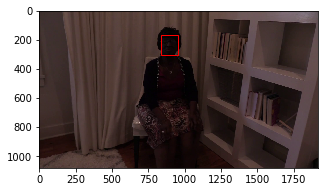

RetinaFace
Found 1 faces


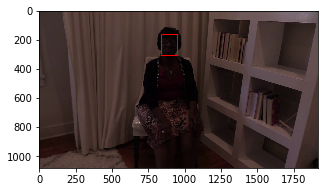

In [21]:
test_detections_on_frame(dark_scene_real_frame)

Both BlazeFace and LightDSFD have some problems.

## Moving People

Some videos contain movement, can we track the people in these vidoes? (**NOTE** This experiment doesn't demonstrate this, but I'm putting it here so you can see the video)

MTCNN
Found 1 faces


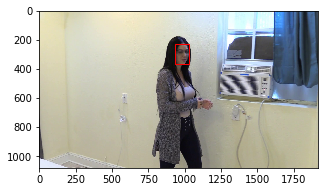

BlazeFace
Found 0 faces


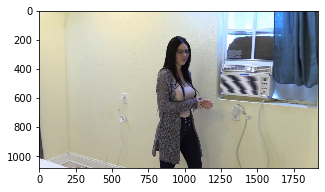

BlazeFace with multiple crops
Found 1 faces


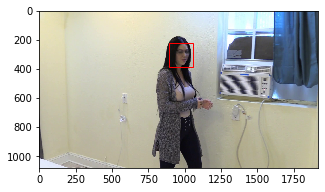

Dual Shot Face Detection
Found 1 faces


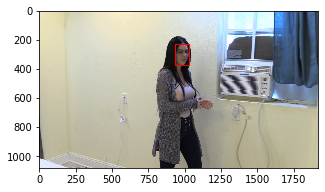

Light DSFD
Found 1 faces


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


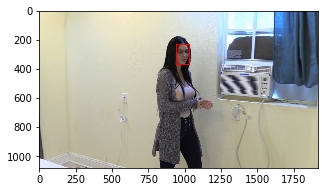

RetinaFace
Found 1 faces


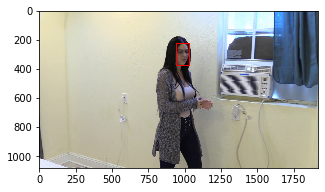

In [22]:
test_detections_on_frame(moving_fake_frame)

MTCNN
Found 1 faces


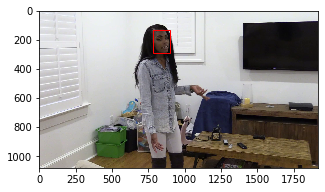

BlazeFace
Found 0 faces


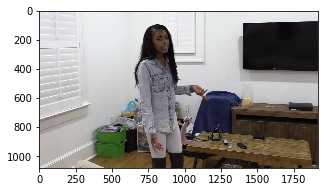

BlazeFace with multiple crops
Found 1 faces


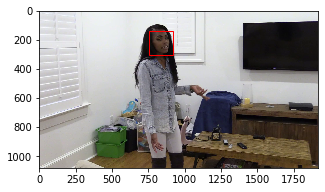

Dual Shot Face Detection
Found 1 faces


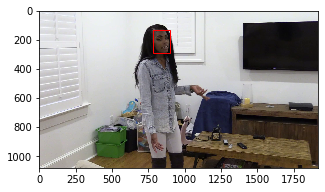

Light DSFD
Found 1 faces


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


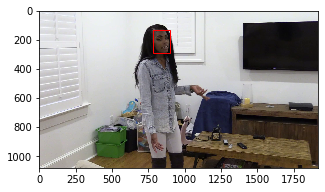

RetinaFace
Found 1 faces


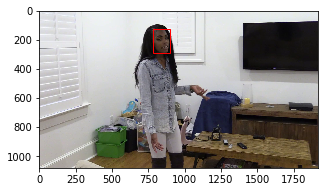

In [23]:
test_detections_on_frame(moving_real_frame)

Once again BlazeFace has problems.

## Obscured Faces

Some of the Deep Fakes corrupt the faces of the individuals we're trying to find. Does this cause problems for our dectors?

MTCNN
Found 1 faces


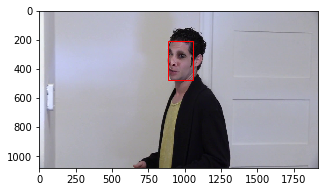

BlazeFace
Found 1 faces


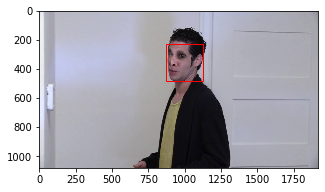

BlazeFace with multiple crops
Found 1 faces


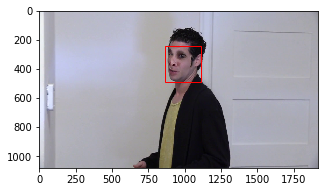

Dual Shot Face Detection
Found 1 faces


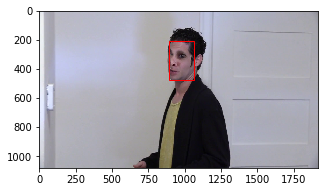

Light DSFD
Found 1 faces


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


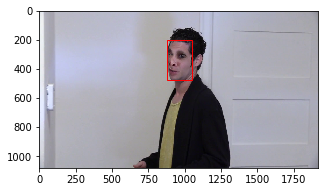

RetinaFace
Found 1 faces


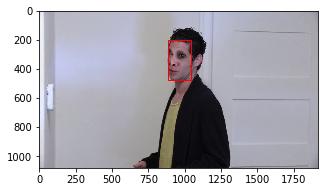

In [24]:
test_detections_on_frame(obscured_face_fake1_frame)

MTCNN
Found 0 faces


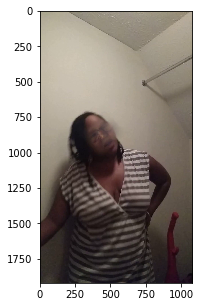

BlazeFace
Found 1 faces


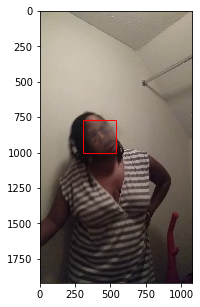

BlazeFace with multiple crops
Found 1 faces


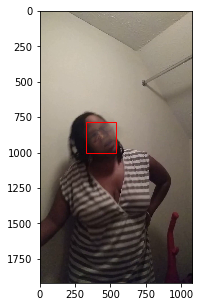

Dual Shot Face Detection
Found 1 faces


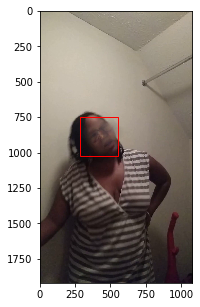

Light DSFD
Found 2 faces


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


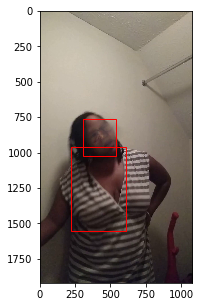

RetinaFace
Found 0 faces


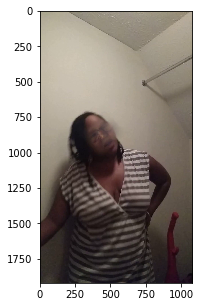

In [25]:
test_detections_on_frame(obscured_face_fake2_frame)

MTCNN
Found 1 faces


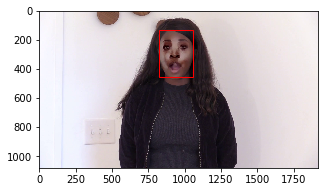

BlazeFace
Found 1 faces


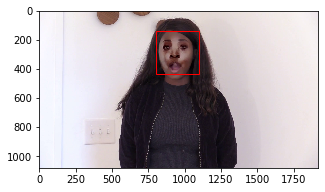

BlazeFace with multiple crops
Found 1 faces


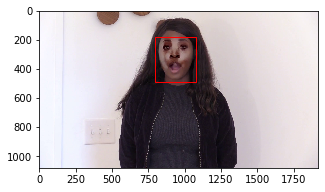

Dual Shot Face Detection
Found 1 faces


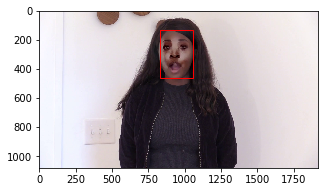

Light DSFD
Found 1 faces


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


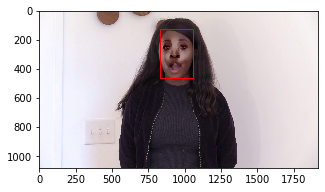

RetinaFace
Found 1 faces


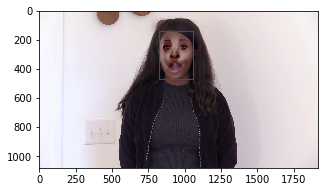

In [26]:
test_detections_on_frame(obscured_face_fake3_frame)

MTCNN
Found 1 faces


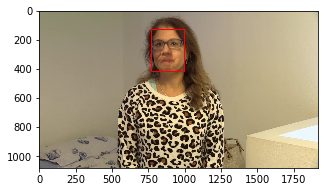

BlazeFace
Found 1 faces


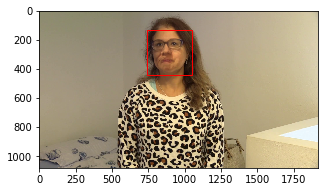

BlazeFace with multiple crops
Found 1 faces


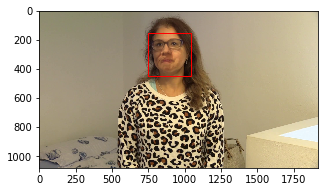

Dual Shot Face Detection
Found 1 faces


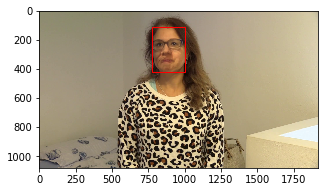

Light DSFD
Found 1 faces


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


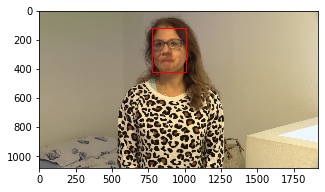

RetinaFace
Found 1 faces


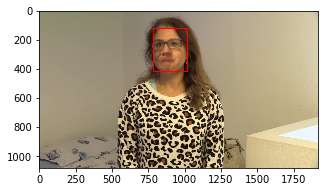

In [27]:
test_detections_on_frame(obscured_face_fake4_frame)

MTCNN
Found 1 faces


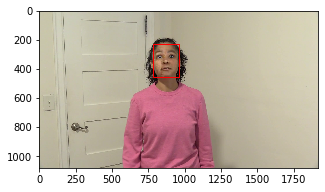

BlazeFace
Found 1 faces


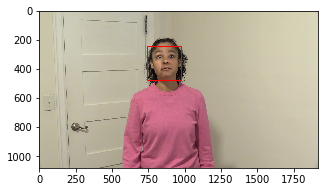

BlazeFace with multiple crops
Found 1 faces


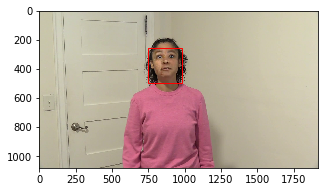

Dual Shot Face Detection
Found 1 faces


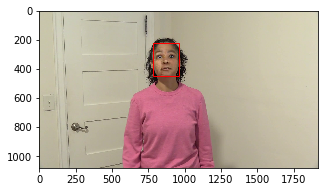

Light DSFD
Found 2 faces


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


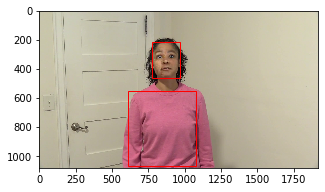

RetinaFace
Found 1 faces


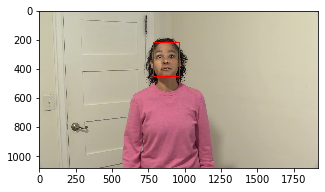

In [28]:
test_detections_on_frame(obscured_face_fake5_frame)

MTCNN, LightDSFD and BlazeFace all had problems.

RetinaFace and DSFD seemed to find all of the faces.

## Run Against Entire Video

So now we would like to run our detectors against entire videos and measure their performance. If a person is present in the video, I believe they are present for every frame. So we can measure the number of frames in which we detect a person and get a rough percentage out.

In [29]:
named_videos = {

'side_profile_fake' : data/'dfdc_train_part_0/bqamrsyvnf.mp4',
'side_profile_real' : data/'dfdc_train_part_11/lqyckwtvnl.mp4',
'two_people_fake' : data/'dfdc_train_part_13/aanzliuzft.mp4',
'two_people_real' : data/'dfdc_train_part_4/bgpoldvzrh.mp4',
'dark_scene_fake' : data/'dfdc_train_part_14/bddpvihkew.mp4',
'dark_scene_real' : data/'dfdc_train_part_5/xyklkuuumr.mp4',
'moving_fake' : data/'dfdc_train_part_7/aqgbewikxk.mp4',
'moving_real' : data/'dfdc_train_part_8/nwzrdkxhql.mp4',
'obscured_face_fake1' : data/'dfdc_train_part_11/czmmoyfilz.mp4',
'obscured_face_fake2' : data/'dfdc_train_part_18/asifdtncje.mp4',
'obscured_face_fake3' : data/'dfdc_train_part_12/asjzklsxgb.mp4',
'obscured_face_fake4' : data/'dfdc_train_part_13/aisumjkudv.mp4',
'obscured_face_fake5' : data/'dfdc_train_part_7/copybkdfji.mp4',
}

In [30]:
def measure_frames_with_detected_person(detector, frames, number_of_people_in_video=1):
    
    # The number of frames in which we detect the correct number of people
    number_correct = 0
    # The number of frames in which we miss one or more people
    number_missing = 0
    # The number of frames in which we detect an additional person
    number_extra = 0
    
    for frame in tqdm(frames):
        detections = detector.detect(frame)
        
        if len(detections) < number_of_people_in_video:
            number_missing = number_missing + 1
        elif len(detections) == number_of_people_in_video:
            number_correct = number_correct + 1
        else:
            number_extra = number_extra + 1
    
    return number_correct, number_missing, number_extra

def benchmark_detector(detector):
    tot_correct = 0
    tot_missing = 0
    tot_extra = 0
    tot_frames = 0
    
    for name, path in named_videos.items():

        all_frames = read_all_frames(path)
        
        #Some vidoes have two people in them, make sure we expect to see both
        expected_num_people = 1
        if "two" in name:
            expected_num_people = 2
            
        n_correct, n_missing, n_extra = measure_frames_with_detected_person(detector, all_frames, expected_num_people)
        
        tot_correct = tot_correct + n_correct
        tot_missing = tot_missing + n_missing
        tot_extra = tot_extra + n_extra
        tot_frames = tot_frames + len(all_frames)

        print()
        print(name)
        print("% Correct", n_correct / len(all_frames))
        print("% Missing", n_missing / len(all_frames))
        print("% Extra", n_extra / len(all_frames))
        
    print("TOTAL")
    print("% Correct", tot_correct / tot_frames)
    print("% Missing", tot_missing / tot_frames)
    print("% Extra", tot_extra / tot_frames)
    
    print('--------------------------------------------------------------------')
    print()

In [51]:
def measure_frames_with_detected_person_multiple_crops(detector, frames, number_of_people_in_video=1):
    
    # The number of frames in which we detect the correct number of people
    number_correct = 0
    # The number of frames in which we miss one or more people
    number_missing = 0
    # The number of frames in which we detect an additional person
    number_extra = 0
    
    for frame in tqdm(frames):
        detections = detector.get_detections_with_multiple_crops(frame)
        
        detections = detections[0]
        
        if len(detections) < number_of_people_in_video:
            number_missing = number_missing + 1
        elif len(detections) == number_of_people_in_video:
            number_correct = number_correct + 1
        else:
            number_extra = number_extra + 1
    
    return number_correct, number_missing, number_extra

def benchmark_detector_blazeface_multiple_crops(detector):
    tot_correct = 0
    tot_missing = 0
    tot_extra = 0
    tot_frames = 0
    
    for name, path in named_videos.items():

        all_frames = read_all_frames(path)
        
        #Some vidoes have two people in them, make sure we expect to see both
        expected_num_people = 1
        if "two" in name:
            expected_num_people = 2
            
        n_correct, n_missing, n_extra = measure_frames_with_detected_person_multiple_crops(detector, 
                                                                                           all_frames, 
                                                                                           expected_num_people)
        
        tot_correct = tot_correct + n_correct
        tot_missing = tot_missing + n_missing
        tot_extra = tot_extra + n_extra
        tot_frames = tot_frames + len(all_frames)

        print()
        print(name)
        print("% Correct", n_correct / len(all_frames))
        print("% Missing", n_missing / len(all_frames))
        print("% Extra", n_extra / len(all_frames))
        
    print("TOTAL")
    print("% Correct", tot_correct / tot_frames)
    print("% Missing", tot_missing / tot_frames)
    print("% Extra", tot_extra / tot_frames)
    
    print('--------------------------------------------------------------------')
    print()

In [37]:
benchmark_detector(easyMTCNN)

In [46]:
#benchmark_detector(easyBlazeFace)

In [52]:
benchmark_detector_blazeface_multiple_crops(easyBlazeFace)



side_profile_fake
% Correct 0.97
% Missing 0.02
% Extra 0.01




side_profile_real
% Correct 0.93
% Missing 0.07
% Extra 0.0




two_people_fake
% Correct 1.0
% Missing 0.0
% Extra 0.0




two_people_real
% Correct 1.0
% Missing 0.0
% Extra 0.0




dark_scene_fake
% Correct 0.4166666666666667
% Missing 0.5733333333333334
% Extra 0.01




dark_scene_real
% Correct 0.5066666666666667
% Missing 0.16666666666666666
% Extra 0.32666666666666666




moving_fake
% Correct 0.8833333333333333
% Missing 0.11333333333333333
% Extra 0.0033333333333333335




moving_real
% Correct 0.99
% Missing 0.0
% Extra 0.01




obscured_face_fake1
% Correct 0.9833333333333333
% Missing 0.0
% Extra 0.016666666666666666




obscured_face_fake2
% Correct 0.8921161825726142
% Missing 0.0
% Extra 0.1078838174273859




obscured_face_fake3
% Correct 1.0
% Missing 0.0
% Extra 0.0




obscured_face_fake4
% Correct 0.9866666666666667
% Missing 0.0
% Extra 0.013333333333333334




obscured_face_fake5
% Correct 0.84
% Missing 0.0
% Extra 0.16
TOTAL
% Correct 0.8765625
% Missing 0.07369791666666667
% Extra 0.04973958333333333
--------------------------------------------------------------------



In [50]:
benchmark_detector(easyDSFD)



side_profile_fake
% Correct 1.0
% Missing 0.0
% Extra 0.0




side_profile_real
% Correct 1.0
% Missing 0.0
% Extra 0.0




two_people_fake
% Correct 1.0
% Missing 0.0
% Extra 0.0




two_people_real
% Correct 1.0
% Missing 0.0
% Extra 0.0




dark_scene_fake
% Correct 1.0
% Missing 0.0
% Extra 0.0




dark_scene_real
% Correct 1.0
% Missing 0.0
% Extra 0.0




moving_fake
% Correct 0.86
% Missing 0.13666666666666666
% Extra 0.0033333333333333335




moving_real
% Correct 1.0
% Missing 0.0
% Extra 0.0




obscured_face_fake1
% Correct 1.0
% Missing 0.0
% Extra 0.0




obscured_face_fake2
% Correct 0.979253112033195
% Missing 0.02074688796680498
% Extra 0.0




obscured_face_fake3
% Correct 1.0
% Missing 0.0
% Extra 0.0




obscured_face_fake4
% Correct 1.0
% Missing 0.0
% Extra 0.0




obscured_face_fake5
% Correct 1.0
% Missing 0.0
% Extra 0.0
TOTAL
% Correct 0.9877604166666667
% Missing 0.011979166666666667
% Extra 0.00026041666666666666
--------------------------------------------------------------------



In [1]:
#benchmark_detector(easyLightDSFD)

In [52]:
benchmark_detector(easyRetinaFace)



side_profile_fake
% Correct 1.0
% Missing 0.0
% Extra 0.0




side_profile_real
% Correct 1.0
% Missing 0.0
% Extra 0.0




two_people_fake
% Correct 1.0
% Missing 0.0
% Extra 0.0




two_people_real
% Correct 1.0
% Missing 0.0
% Extra 0.0




dark_scene_fake
% Correct 1.0
% Missing 0.0
% Extra 0.0




dark_scene_real
% Correct 1.0
% Missing 0.0
% Extra 0.0




moving_fake
% Correct 0.7466666666666667
% Missing 0.25333333333333335
% Extra 0.0




moving_real
% Correct 1.0
% Missing 0.0
% Extra 0.0




obscured_face_fake1
% Correct 1.0
% Missing 0.0
% Extra 0.0




obscured_face_fake2
% Correct 0.9543568464730291
% Missing 0.04564315352697095
% Extra 0.0




obscured_face_fake3
% Correct 1.0
% Missing 0.0
% Extra 0.0




obscured_face_fake4
% Correct 1.0
% Missing 0.0
% Extra 0.0




obscured_face_fake5
% Correct 1.0
% Missing 0.0
% Extra 0.0
TOTAL
% Correct 0.97734375
% Missing 0.02265625
% Extra 0.0
--------------------------------------------------------------------



### Percentage of frames with correct number of detections

| Model      | **total** | side_profile_fake | side_profile_real | two_people_fake | two_people_real | dark_scene_fake | dark_scene_real | moving_fake | moving_real | obscured_face_fake1 | obscured_face_fake2 | obscured_face_fake3 | obscured_face_fake4 | obscured_face_fake5
|------------|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
| MTCNN              |**0.875**|0.48|0.96|0.94|0.99|1.00|0.85|0.65|0.92|0.98|0.89|1.00|0.72|1.00|
| BlazeFace          |**0.610**|0.00|0.17|0.95|0.84|0.00|0.10|0.34|0.61|1.00|1.00|1.00|1.00|1.00|
| BlazeFace 3 crops  |**0.877**|0.97|0.93|1.00|1.00|0.42|0.50|0.88|0.99|0.98|0.89|1.00|0.987|0.84|
| DSFD               |**0.988**|1.00|1.00|1.00|1.00|1.00|1.00|0.86|1.00|1.00|0.97|1.00|1.00|1.00|
| LightDSFD          |         |0.97|0.99|1.00|1.00|0.12|ERR | -- | -- | -- | -- | -- | -- | -- |
| RetinaFace         |**0.977**|1.00|1.00|1.00|1.00|1.00|1.00|0.75|1.00|1.00|0.95|1.00|1.00|1.00|




### Approx. Runtimes for each algorithm

These are very, very loose times.

Units are **iterations/second**. (Higher is better)

| Model      | **avg** | side_profile_fake | side_profile_real | two_people_fake | two_people_real | dark_scene_fake | dark_scene_real | moving_fake | moving_real | obscured_face_fake1 | obscured_face_fake2 | obscured_face_fake3 | obscured_face_fake4 | obscured_face_fake5
|------------|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
| MTCNN      |**7.40**|14.9|2.04|2.24|2.47|2.87|3.29|4.33|5.79|8.69|12.0|20.2|14.3|3.08|
| BlazeFace  |**36.8**|3.03|16.8|20.4|31.6|67.8|2.96|25.9|45.3|174.3|15.1|26.2|46.8|2.85|
| DSFD       |**1.69**|1.08|1.54|1.97|1.76|1.32|1.14|2.26|2.34|1.65|1.52|1.16|2.33|1.85|
| LightDSFD  |**ERR**|    |    |    |    |    |    |    |    |    |    |    |    |    |
| RetinaFace |**3.06**|2.11|4.45|4.58|1.12|1.51|2.26|4.65|1.17|1.59|1.97|4.63|4.91|4.91|